In [1]:
import tensorrt
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

2023-06-28 13:04:14.475181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Convolutional layers and their shapes

2023-06-27 14:39:13.820046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 14:39:13.930347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 14:39:13.930401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 14:39:13.933050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-27 14:39:13.933087: I tensorflow/compile

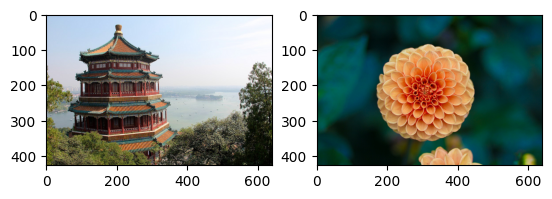

In [4]:
images = tf.constant(load_sample_images()['images'])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images[0])
ax2.imshow(images[1])
display()

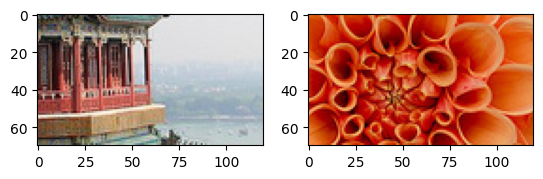

In [5]:
images2 = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images2 = tf.keras.layers.Rescaling(scale=1/256)(images2)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images2[0])
ax2.imshow(images2[1])
display()

In [6]:
images2.shape

TensorShape([2, 70, 120, 3])

In [7]:
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=7)
fmaps = conv_layer(images2)
fmaps.shape

2023-06-27 14:39:17.395460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-06-27 14:39:18.457650: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


TensorShape([2, 64, 114, 32])

In [8]:
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=7, padding='same')
fmaps = conv_layer(images2)
fmaps.shape

TensorShape([2, 70, 120, 32])

In [9]:
conv_layer = tf.keras.layers.Conv2D(32, kernel_size=7, padding='same', strides=2)
fmaps = conv_layer(images2)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [10]:
kernels, biases = conv_layer.get_weights()
print(kernels.shape)
print(biases.shape)

(7, 7, 3, 32)
(32,)


# Pooling layers

(2, 427, 640, 3)
(2, 213, 320, 3)


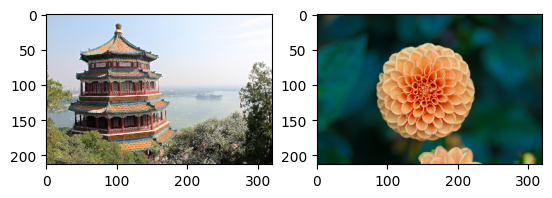

In [11]:
# By default, strides is equal to pool size if not provided
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
images3 = max_pool(images)
print(images.shape)
print(images3.shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(images3[0])
ax2.imshow(images3[1])
display()

## Implementing a max pooling layer that works on the depth dimension

In [79]:
class DepthMaxPooling(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    # input ~ (batch, height, width, input_channels)
    # output ~ (batch, height, width, input_channels / pool size)
    def my_call(self, input):
        tensor = None
        for d in tf.range(input.shape[-1] // self.pool_size):
            new_layer = tf.reduce_max(input[..., d * self.pool_size : (d + 1) * self.pool_size], axis=-1, keepdims=True)
            tensor = tf.concat([x for x in [tensor, new_layer] if x is not None], axis=-1)
        return tensor

    # This neat method "breaks down" the last axis to the number of groups.
    # However, it only works if the number of groups x pool size equals the depth exactly
    def book_call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

    def fixed_book_call(self, inputs):
        trailing_zeros = (self.pool_size - inputs.shape[-1] % self.pool_size) % self.pool_size
        paddings = tf.constant([[0, 0], [0, 0], [0, 0], [0, trailing_zeros]])
        inputs = tf.pad(inputs, paddings)
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

    def call(self, inputs):
        return self.fixed_book_call(inputs)

    def get_config(self):
        base_config = super().get_config()
        return { **base_config, 'pool_size': self.pool_size }

In [90]:
# shape=(3, 2, 2, 4)
test_input = tf.constant(
    [[[[1., 2., 3., 4., 9.],
         [5., 6., 7., 8., 9.]],

        [[9., 10., 11., 12., 9.],
         [13., 14., 15., 16., 9.]]],


       [[[10., 20., 30., 40., 9.],
         [50., 60., 70., 80., 9.]],

        [[90., 100., 110., 120., 9.],
         [130., 140., 150., 160, 9.]]],


       [[[100., 200., 300., 400., 9.],
         [500., 600., 700., 800., 9.]],

        [[900., 1000., 1100., 1200., 9.],
         [1300., 1400., 1500., 1600., 9.]]]], dtype=tf.float32
)

# shape = tf.shape(test_input)
# print(shape)
# groups = shape[-1] // 2
# print(groups)
# new_shape = tf.concat([shape[:-1], [groups, 2]], axis=0)
# print(new_shape)
# tf.reshape(test_input, new_shape)

# pool_size = 2
# trailing_zeros = (pool_size - test_input.shape[-1] % pool_size) % pool_size
# paddings = tf.constant([[0, 0], [0, 0], [0, 0], [0, trailing_zeros]])
# test_input = tf.pad(test_input, paddings)

dmp = DepthMaxPooling(pool_size=2)
dmp(test_input)
# a = tf.reduce_max(test_input[..., 0:2], axis=-1, keepdims=True)
# b = tf.reduce_max(test_input[..., 2:4], axis=-1, keepdims=True)
# tf.concat([a], axis=-1)

<tf.Tensor: shape=(3, 2, 2, 3), dtype=float32, numpy=
array([[[[   2.,    4.,    9.],
         [   6.,    8.,    9.]],

        [[  10.,   12.,    9.],
         [  14.,   16.,    9.]]],


       [[[  20.,   40.,    9.],
         [  60.,   80.,    9.]],

        [[ 100.,  120.,    9.],
         [ 140.,  160.,    9.]]],


       [[[ 200.,  400.,    9.],
         [ 600.,  800.,    9.]],

        [[1000., 1200.,    9.],
         [1400., 1600.,    9.]]]], dtype=float32)>

# Models

## Model 1

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

train = tf.data.Dataset.from_tensor_slices((x_train[6000:], y_train[6000:])).shuffle(10000).batch(32).prefetch(1)
valid = tf.data.Dataset.from_tensor_slices((x_train[:6000], y_train[:6000])).batch(32).prefetch(1)
test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(1)

In [12]:
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape(target_shape=(28, 28, 1), input_shape=(28, 28)),
    tf.keras.layers.Rescaling(scale=1/256),
    DefaultConv2D(filters=64, kernel_size=7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

In [11]:
from pathlib import Path

model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)

root_dir = Path('data/02-fashion-mnist')
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint(root_dir / 'model', save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_dir / 'tensorboard')

hist = model.fit(
    train,
    epochs=100,
    validation_data=valid,
    callbacks=[early_stop_cb, checkpoints_cb, tensorboard_cb]
)

ValueError: in user code:

    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/amitaharoni/miniconda3/envs/tf/lib/python3.11/site-packages/keras/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "conv2d_10" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 28, 28)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 28, 28), dtype=uint8)
      • training=True
      • mask=None


In [8]:
model.evaluate(test)

 11/313 [>.............................] - ETA: 5s - loss: 0.2935 - sparse_categorical_accuracy: 0.9233

2023-06-27 17:09:30.720096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000]
	 [[{{node Placeholder/_1}}]]


313/313 [==============================] - 2s 5ms/step - loss: 0.2710 - sparse_categorical_accuracy: 0.9128


[0.27101919054985046, 0.9128000140190125]

In [ ]:
tf.keras.layers.DepthwiseConv2D